#### Install and import Python libraries

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import sys

root_dir = ".."
sys.path.append(os.path.join(root_dir, "src"))


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm.autonotebook import tqdm

import torch
from torch.utils.data import DataLoader

from tracker.data_track import MOT16Sequences
from tracker.data_obj_detect import MOT16ObjDetect
from tracker.object_detector import FRCNN_FPN
from tracker.tracker import Tracker
from tracker.utils import (plot_sequence, evaluate_mot_accums, get_mot_accum,
                           evaluate_obj_detect, obj_detect_transforms)
from gnn.models import BipartiteNeuralMessagePassingLayer, SimilarityNet
# from gnn.tracker import MPNTracker

from scipy.optimize import linear_sum_assignment as linear_assignment
from market.models import build_model
from tracker.tracker import Tracker, ReIDTracker
import os.path as osp

import motmetrics as mm
mm.lap.default_solver = 'lap'
%matplotlib inline


/tmp/ipykernel_31883/206780436.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm



## Configuration

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


# Multi-object tracking

## Configuration

In [5]:
seed = 12345
#seq_name = "MOT16-reid"  # We recommend to use this subset.
#data_dir = os.path.join(root_dir, "data/MOT16")
#output_dir = os.path.join(root_dir, "output")


## load pretrained

### Reid model

In [6]:
model_path = root_dir + "/models/resnet50_reid.pth"

reid_model = build_model("resnet34", 751, loss="softmax", pretrained=True)
reid_ckpt = torch.load(model_path)
reid_model.load_state_dict(reid_ckpt)
reid_model = reid_model.cuda()


#### Object detector

The object detector is a [Faster R-CNN](https://arxiv.org/abs/1506.01497) with a Resnet50 feature extractor. We trained the native PyTorch implementation of Faster-RCNN. For more information check out the corresponding PyTorch [webpage](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).

In [7]:

obj_detect_model_file = os.path.join(root_dir, "models/faster_rcnn_fpn.model")
obj_detect_nms_thresh = 0.3

# object detector
obj_detect = FRCNN_FPN(num_classes=2, nms_thresh=obj_detect_nms_thresh)
obj_detect_state_dict = torch.load(
    obj_detect_model_file, map_location=lambda storage, loc: storage
)
obj_detect.load_state_dict(obj_detect_state_dict)
obj_detect.eval()
obj_detect = obj_detect.to(device)

/data/home/m.goldin/anaconda3/envs/tracking/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' and 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
/data/home/m.goldin/anaconda3/envs/tracking/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [8]:
# Define our model, and init
refine_gnn_net = SimilarityNet(
    reid_network=None,  # Not needed since we work with precomputed features
    node_dim=32,
    edge_dim=64,
    reid_dim=512,
    edges_in_dim=6,
    num_steps=10,
).cuda()

In [9]:
best_ckpt = torch.load(osp.join(root_dir, "output", "best_ckpt.pth"))
refine_gnn_net.load_state_dict(best_ckpt)


<All keys matched successfully>

## Setup

In [10]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True


# Train from raw seq

## Infer without predefined features, from raw sequences

In [12]:
class ReIDHungarianIoUTracker2(ReIDTracker):
    def data_association(self, boxes, scores, frame):
        crops = self.get_crop_from_boxes(boxes, frame)
        pred_features = self.compute_reid_features(reid_model, crops).cpu().clone()

        if self.tracks:
            track_ids = [t.id for t in self.tracks]
            track_boxes = torch.stack([t.box for t in self.tracks], axis=0)
            track_features = torch.stack([t.get_feature() for t in self.tracks], axis=0)

            # This will use your similarity measure. Please use cosine_distance!
            distance = self.compute_distance_matrix(
                track_features,
                pred_features,
                track_boxes,
                boxes,
                metric_fn=cosine_distance,
            )

            # Perform Hungarian matching.
            row_idx, col_idx = linear_assignment(distance)
            self.update_tracks(row_idx, col_idx, distance, boxes, scores, pred_features)

        else:
            # No tracks exist.
            self.add(boxes, scores, pred_features)


    def update_tracks(self, row_idx, col_idx, distance, boxes, scores, pred_features):
        # row_idx and col_idx are indices into track_boxes and boxes.
        # row_idx[i] and col_idx[i] define a match.
        # distance[row_idx[i], col_idx[i]] define the cost for that matching.
        track_ids = [t.id for t in self.tracks]

        remove_track_ids = []
        seen_track_ids = []
        seen_box_idx = []
        # Update existing tracks and remove unmatched tracks.

        for track_idx, box_idx in zip(row_idx, col_idx):
            costs = distance[track_idx, box_idx]
            internal_track_id = track_ids[track_idx]
            seen_track_ids.append(internal_track_id)
            # If the costs are equal to _UNMATCHED_COST, it's not a match.
            if costs == _UNMATCHED_COST:
                remove_track_ids.append(internal_track_id)
            else:
                self.tracks[track_idx].box = boxes[box_idx]
                self.tracks[track_idx].add_feature(pred_features[box_idx])
                seen_box_idx.append(box_idx)

        unseen_track_ids = set(track_ids) - set(seen_track_ids)
        remove_track_ids.extend(list(unseen_track_ids))
        self.tracks = [t for t in self.tracks if t.id not in remove_track_ids]

        # update the feature of a track by using add_feature:
        # self.tracks[my_track_id].add_feature(pred_features[my_feat_index])
        # use the mean feature from the last 10 frames for ReID.

        new_boxes_idx = set(range(len(boxes))) - set(seen_box_idx)
        new_boxes = [boxes[i] for i in new_boxes_idx]
        new_scores = [scores[i] for i in new_boxes_idx]
        new_features = [pred_features[i] for i in new_boxes_idx]
        self.add(new_boxes, new_scores, new_features)



In [17]:
_UNMATCHED_COST = 255.0
class MPNTracker(ReIDHungarianIoUTracker2):
    def __init__(self, refine_gnn_net, reid_model, *args, **kwargs):
        self.refine_gnn_net = refine_gnn_net
        self.reid_model = reid_model
        super().__init__(*args, **kwargs)

    def data_association(self, boxes, scores, frame #pred_features
                        ):
        crops = self.get_crop_from_boxes(boxes, frame)
        pred_features = self.compute_reid_features(reid_model, crops).cpu().clone()
        
        
        if self.tracks:
            track_boxes = torch.stack([t.box for t in self.tracks], axis=0).cuda()
            track_features = torch.stack(
                [t.get_feature() for t in self.tracks], axis=0
            ).cuda()

            # Hacky way to recover the timestamps of boxes and tracks
            curr_t = self.im_index * torch.ones((pred_features.shape[0],)).cuda()
            track_t = torch.as_tensor(
                [self.im_index - t.inactive - 1 for t in self.tracks]
            ).cuda()

            # Do a forward pass through self.assign_net to obtain our costs.
            edges_raw_logits = self.refine_gnn_net(
                track_features.cuda(),
                pred_features.cuda(),
                track_boxes.cuda(),
                boxes.cuda(),
                track_t,
                curr_t,
            )
            # Note: self.assign_net will return unnormalized probabilities.
            # apply the sigmoid function to them!
            pred_sim = torch.sigmoid(edges_raw_logits).detach().cpu().numpy()
            pred_sim = pred_sim[-1]  # Use predictions at last message passing step
            distance = 1 - pred_sim
            #print(pred_sim)
            # Do not allow mataches when sim < 0.5, to avoid low-confident associations
            distance = np.where(pred_sim < 0.5, _UNMATCHED_COST, distance)
            
            # Perform Hungarian matching.
            row_idx, col_idx = linear_assignment(distance)
            self.update_tracks(row_idx, col_idx, distance, boxes, scores, pred_features)


        else:
            # No tracks exist.
            self.add(boxes, scores, pred_features)


In [18]:

#tracker = ReIDHungarianIoUTracker(obj_detect)
#tracker = ReIDHungarianIoUTracker2(obj_detect)

tracker = MPNTracker(
    refine_gnn_net = refine_gnn_net.eval(),
    reid_model = reid_model,
    obj_detect = obj_detect
)


In [20]:
val_sequences = MOT16Sequences(
            "MOT16-val2", osp.join(root_dir, "data/MOT16"), vis_threshold=0.0
        )
print('seqs',[str(s) for s in val_sequences if not s.no_gt])

seqs ['MOT16-02', 'MOT16-11']


In [21]:
time_total = 0
mot_accums = []
results_seq = {}
for seq in val_sequences:
    tracker.reset()
    now = time.time()

    print(f"Tracking: {seq}")

    data_loader = DataLoader(seq, batch_size=1, shuffle=False)
    for frame in tqdm(data_loader):
        tracker.step(frame)

    results = tracker.get_results()
    results_seq[str(seq)] = results

    if seq.no_gt:
        print(f"No GT evaluation data available.")
    else:
        mot_accums.append(get_mot_accum(results, seq))

    time_total += time.time() - now

    print(f"Tracks found: {len(results)}")
    print(f"Runtime for {seq}: {time.time() - now:.1f} s.")

    # seq.write_results(results, os.path.join(output_dir))

print(f"Runtime for all sequences: {time_total:.1f} s.")
if mot_accums:
    evaluate_mot_accums(
        mot_accums, [str(s) for s in val_sequences if not s.no_gt], generate_overall=True
    )


Tracking: MOT16-02


100%|█████████████████████████████████████████| 600/600 [02:16<00:00,  4.40it/s]


Tracks found: 325
Runtime for MOT16-02: 136.9 s.
Tracking: MOT16-11


100%|█████████████████████████████████████████| 900/900 [02:42<00:00,  5.54it/s]


Tracks found: 190
Runtime for MOT16-11: 162.8 s.
Runtime for all sequences: 299.7 s.
          IDF1   IDP   IDR  Rcll  Prcn  GT MT PT ML  FP    FN IDs   FM  MOTA  MOTP IDt IDa IDm
MOT16-02 42.7% 60.7% 33.0% 52.3% 96.2%  62 11 38 13 383  8870 191  214 49.2% 0.095  24 167   4
MOT16-11 62.6% 69.0% 57.3% 80.2% 96.6%  75 42 26  7 266  1868  83   86 76.5% 0.083  13  71   3
OVERALL  50.2% 64.3% 41.1% 61.7% 96.4% 137 53 64 20 649 10738 274  300 58.4% 0.090  37 238   7


## Baseline Tracker Results

            IDF1   IDP   IDR   Rcll  Prcn  GT  MT  PT ML  FP   FN IDs   FM  MOTA  MOTP
    MOT16-02 32.2% 49.8% 23.8% 30.8% 64.4%  62  5  22 35 3170 12858  52   93 13.5% 0.086
    MOT16-05 47.7% 53.9% 42.8% 57.8% 72.7% 133 39  64 30 1502  2917  87  103 34.9% 0.144
    MOT16-09 43.0% 48.8% 38.4% 51.9% 66.1%  26  7  14  5 1420  2559  39   66 24.5% 0.107
    MOT16-11 49.0% 54.1% 44.8% 55.8% 67.5%  75 15  32 28 2542  4166  20   39 28.7% 0.080
    OVERALL  41.0% 51.8% 33.9% 44.1% 67.3% 296 66 132 98 8634 22500 198  301 22.2% 0.101

## Hungarian Tracker Results

             IDF1    IDP  IDR  Rcll  Prcn   GT  MT  PT ML   FP    FN IDs   FM  MOTA  MOTP 
    MOT16-02 39.1% 55.5% 30.2% 52.3% 96.2%  62  11  38 13  383  8870 246  215 48.9% 0.096 
    MOT16-05 55.1% 65.2% 47.7% 68.8% 94.2% 133  55  66 12  295  2158 199  155 61.7% 0.143  
    MOT16-09 50.2% 62.0% 42.1% 66.4% 97.8%  26  13  12  1   80  1789  76   78 63.5% 0.083  
    MOT16-11 60.4% 66.6% 55.3% 80.2% 96.6%  75  42  26  7  266  1868  99   86 76.3% 0.083  
    OVERALL  49.0% 61.5% 40.6% 63.5% 96.2% 296 121 142 33 1024 14685 620  534 59.4% 0.099 

# ReidHungarianIoU Tracker results

              IDF1   IDP   IDR  Rcll  Prcn  GT  MT  PT ML   FP    FN IDs   FM  MOTA  MOTP IDt IDa IDm
    MOT16-02 41.0% 58.2% 31.6% 52.3% 96.2%  62  11  38 13  383  8870 334  221 48.4% 0.095 173 154  10
    MOT16-05 55.8% 66.1% 48.3% 68.8% 94.2% 133  56  65 12  295  2158 218  150 61.4% 0.142  96 144  25
    MOT16-09 52.4% 64.7% 44.0% 66.4% 97.8%  26  12  13  1   80  1789  80   79 63.4% 0.083  27  58   5
    MOT16-11 62.2% 68.6% 56.9% 80.2% 96.6%  75  42  26  7  266  1868 112   86 76.2% 0.083  41  77  11
    OVERALL  50.6% 63.7% 42.1% 63.5% 96.2% 296 121 142 33 1024 14685 744  536 59.1% 0.099 337 433  51

# ReidHungarianIoU Tracker results

              IDF1   IDP   IDR  Rcll  Prcn  GT MT PT ML  FP    FN IDs   FM  MOTA  MOTP IDt IDa IDm
    MOT16-02 42.7% 60.7% 33.0% 52.3% 96.2%  62 11 38 13 383  8870 191  214 49.2% 0.095  24 167   4
    MOT16-11 62.6% 69.0% 57.3% 80.2% 96.6%  75 42 26  7 266  1868  83   86 76.5% 0.083  13  71   3
    OVERALL  50.2% 64.3% 41.1% 61.7% 96.4% 137 53 64 20 649 10738 274  300 58.4% 0.090  37 238   7

## Visualize tracking results

### new

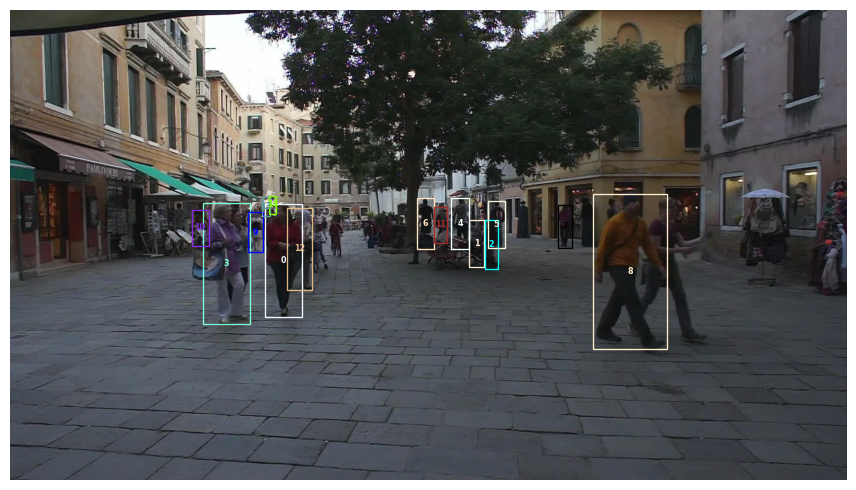

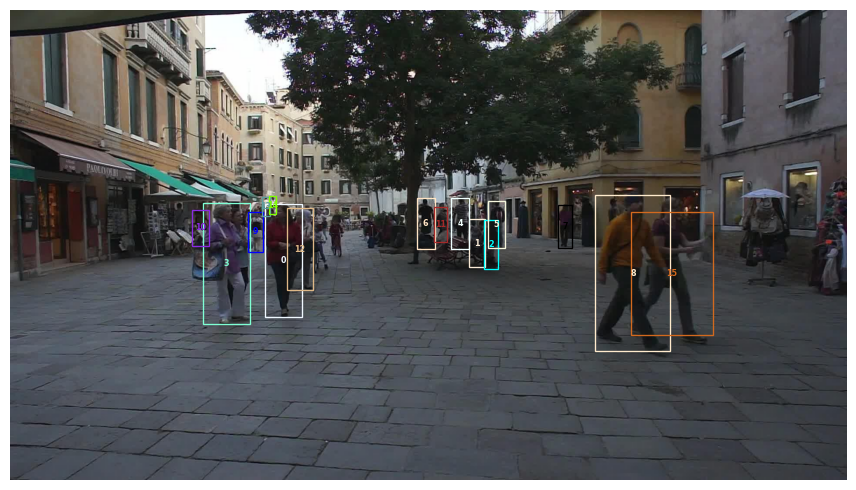

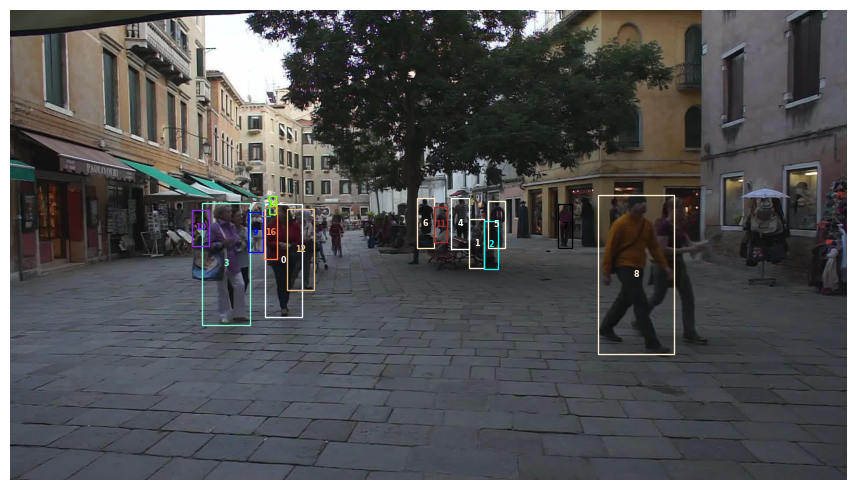

In [26]:
plot_sequence(
    results_seq["MOT16-02"],
    [s for s in val_sequences if str(s) == "MOT16-02"][0],
    first_n_frames=3,
)


In [71]:
import gif

In [72]:
import random
from matplotlib import pyplot as plt
import gif

x = [random.randint(0, 100) for _ in range(100)]
y = [random.randint(0, 100) for _ in range(100)]

# (Optional) Set the dots per inch resolution to 300:
gif.options.matplotlib["dpi"] = 300


In [79]:

# Decorate a plot function with @gif.frame (return not required):
@gif.frame
def plot(i):
    xi = x[i*10:(i+1)*10]
    yi = y[i*10:(i+1)*10]
    plt.scatter(xi, yi)
    plt.xlim((0, 100))
    plt.ylim((0, 100))

# Build a bunch of "frames"
frames = []
for i in range(10):
    frame = plot(i)
    frames.append(frame)

# Specify the duration between frames (milliseconds) and save to file:


In [80]:
frames

[<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1920x1440>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1920x1440>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1920x1440>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1920x1440>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1920x1440>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1920x1440>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1920x1440>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1920x1440>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1920x1440>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1920x1440>]

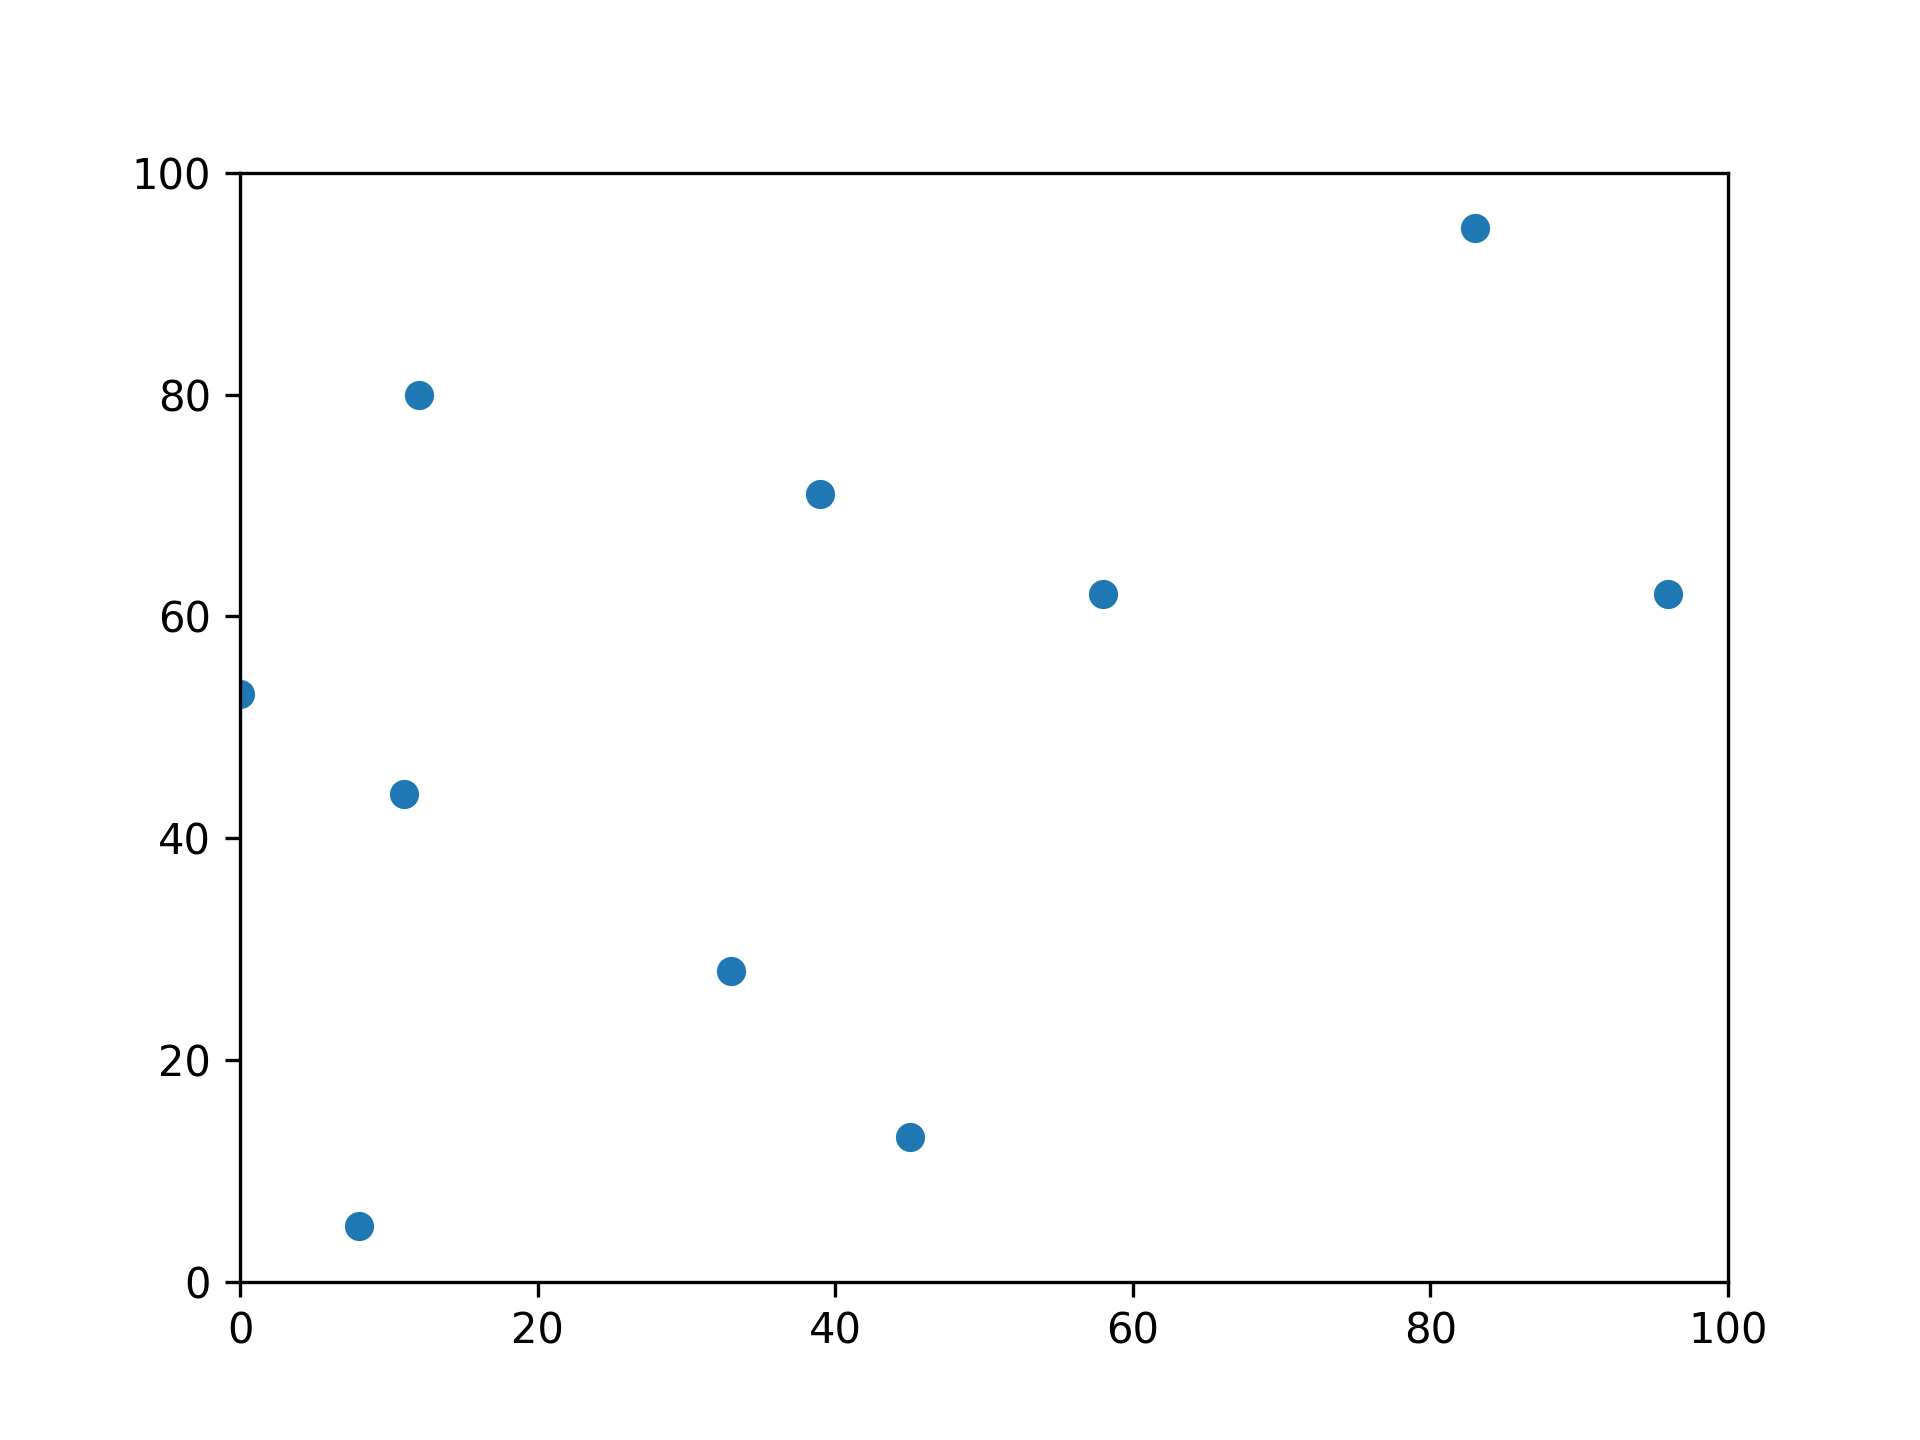

In [82]:
frames[2]

In [34]:
@gif.frame
def plot_sequence2(tracks, db, first_n_frames=None):
    """Plots a whole sequence

    Args:
        tracks (dict): The dictionary containing the track dictionaries in the form tracks[track_id][frame] = bb
        db (torch.utils.data.Dataset): The dataset with the images belonging to the tracks (e.g. MOT_Sequence object)
    """

    # print("[*] Plotting whole sequence to {}".format(output_dir))

    # if not osp.exists(output_dir):
    # 	os.makedirs(output_dir)

    # infinite color loop
    cyl = cy("ec", colors)
    loop_cy_iter = cyl()
    styles = defaultdict(lambda: next(loop_cy_iter))

    for i, v in enumerate(db):
        

        if first_n_frames is not None and first_n_frames - 1 == i:
            break

In [182]:
@gif.frame
def plot_single_frame(v, tracks):
    img = v["img"].mul(255).permute(1, 2, 0).byte().numpy()
    width, height, _ = img.shape

    dpi = 300
    fig, ax = plt.subplots(1, dpi=dpi)
    #fig.set_size_inches(width / dpi, height / dpi)
    ax.set_axis_off()
    ax.imshow(img)
   
    #plt.scatter(xi, yi)
    
    for j, t in tracks.items():
        if i in t.keys():
            t_i = t[i]
            ax.add_patch(
                plt.Rectangle(
                    (t_i[0], t_i[1]),
                    t_i[2] - t_i[0],
                    t_i[3] - t_i[1],
                    fill=False,
                    linewidth=1.0,
                    **styles[j],
                )
            )

            ax.annotate(
                j,
                (
                    t_i[0] + (t_i[2] - t_i[0]) / 2.0,
                    t_i[1] + (t_i[3] - t_i[1]) / 2.0,
                ),
                color=styles[j]["ec"],
                weight="bold",
                fontsize=6,
                ha="center",
                va="center",
            )

    #plt.axis("off")
    # plt.tight_layout()
    #plt.show()
    # plt.savefig(im_output, dpi=100)
    # plt.close()

In [183]:
single_seq = [s for s in val_sequences if str(s) == "MOT16-02"][0]

In [184]:
from cycler import cycler as cy
from tracker.utils import colors
from collections import defaultdict


In [191]:
frames = []

cyl = cy("ec", colors)
loop_cy_iter = cyl()
styles = defaultdict(lambda: next(loop_cy_iter))
first_n_frames = None
for i, v in enumerate(single_seq):
    frame = plot_single_frame(v, results_seq["MOT16-02"])
    frames.append(frame)
    if first_n_frames is not None and first_n_frames - 1 == i:
        break
    

In [192]:
len(frames)

600

In [193]:
#frames

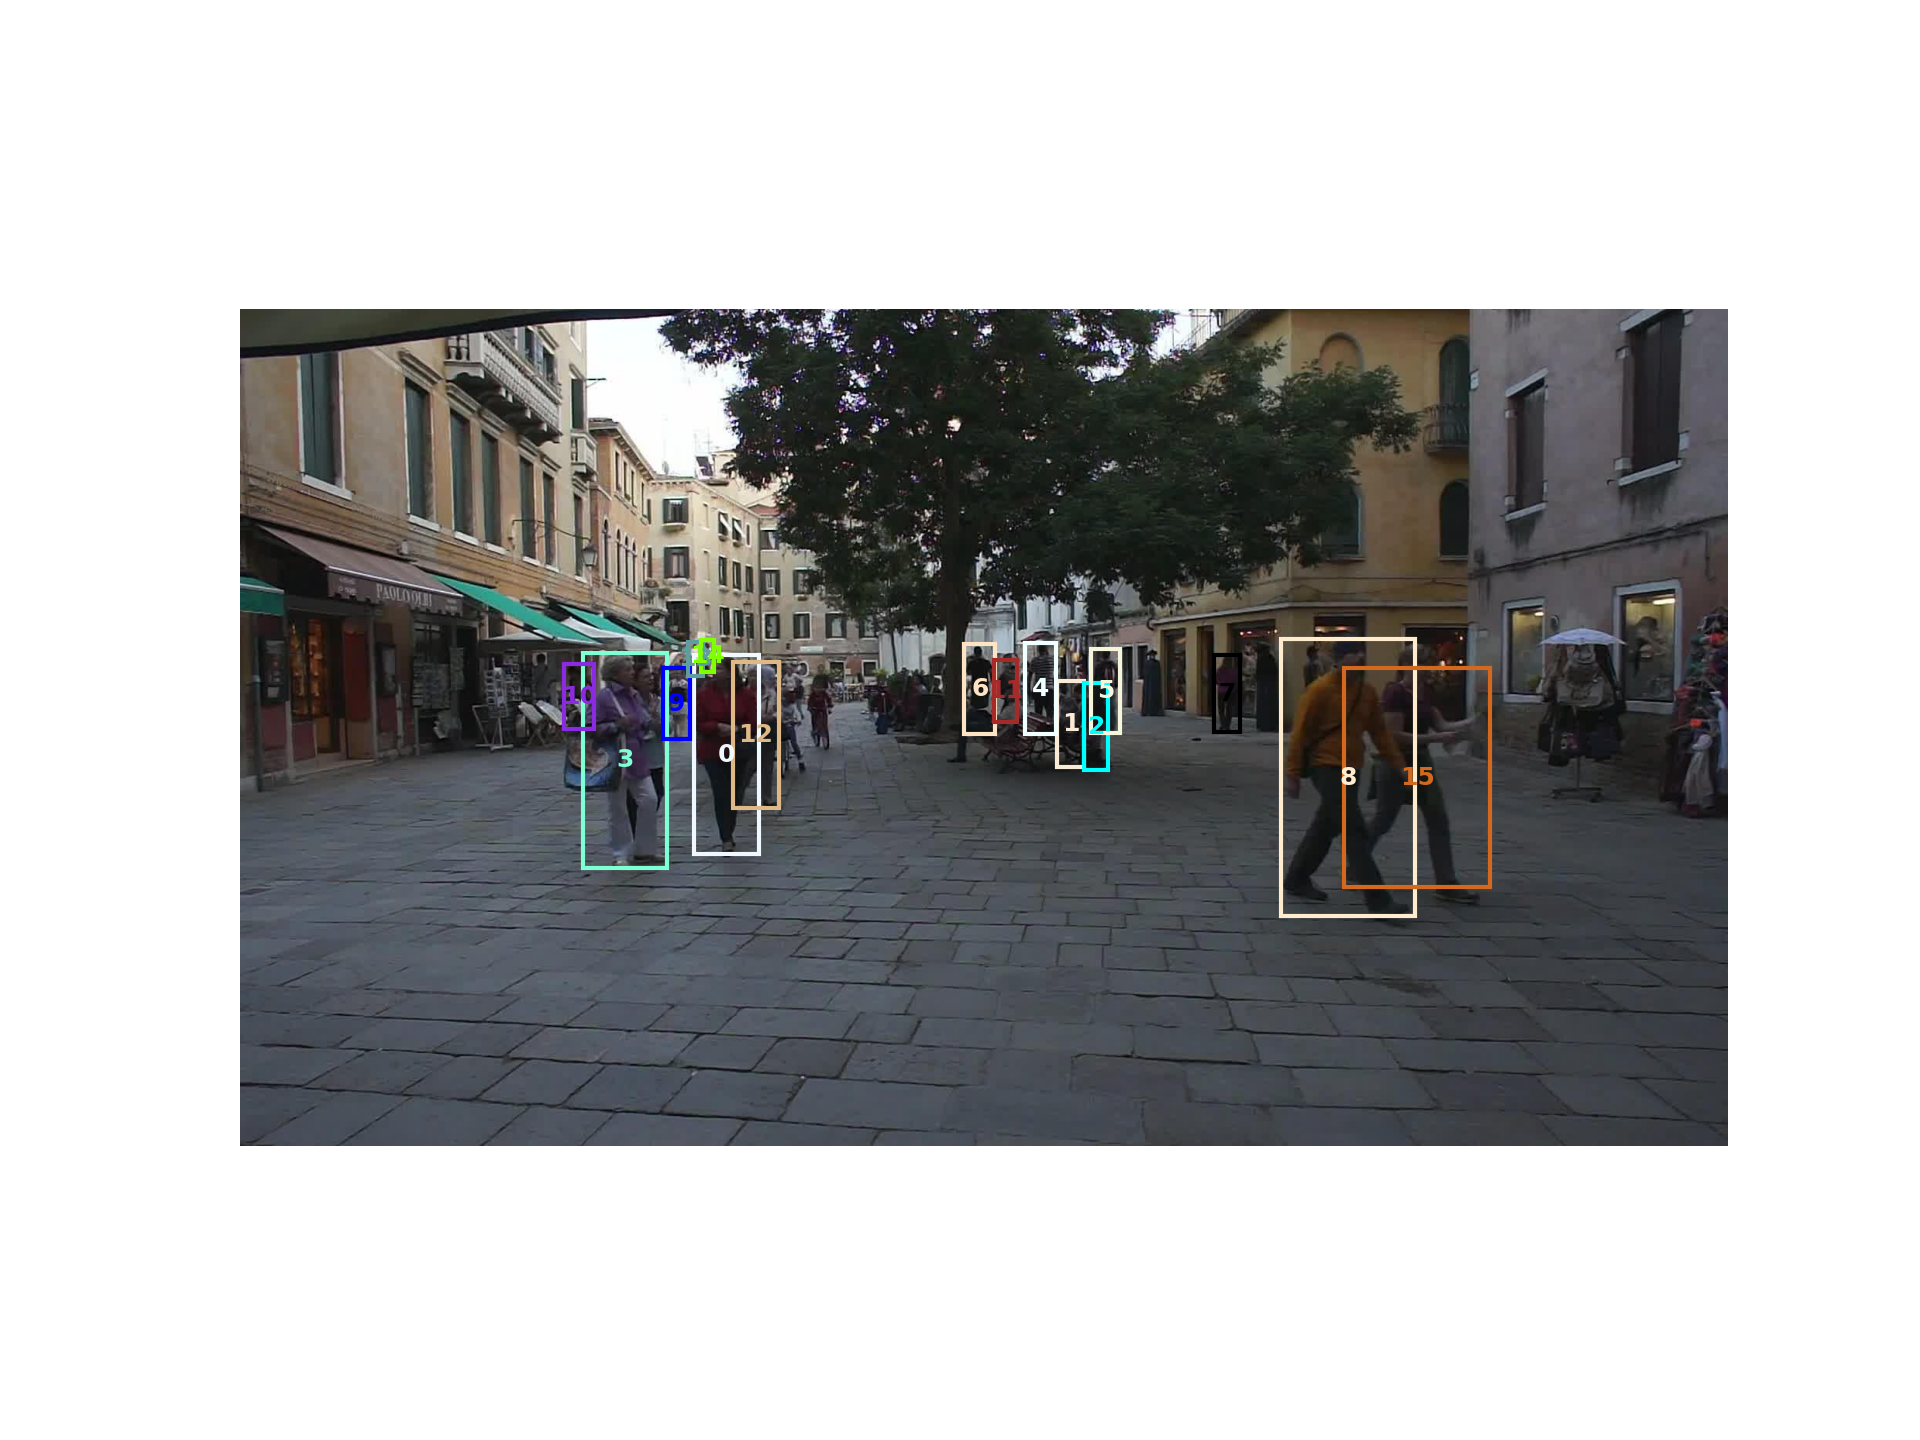

In [194]:
frames[1]

In [195]:
gif.save(frames, 'cv3ds5_result_tmp.gif', duration=10)

In [196]:
frames = None

In [ ]:
plot_sequence(
    results_seq["MOT16-02"],
    [s for s in val_sequences if str(s) == "MOT16-02"][0],
    first_n_frames=3,
)


In [61]:
frames

[<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1920x1440>]

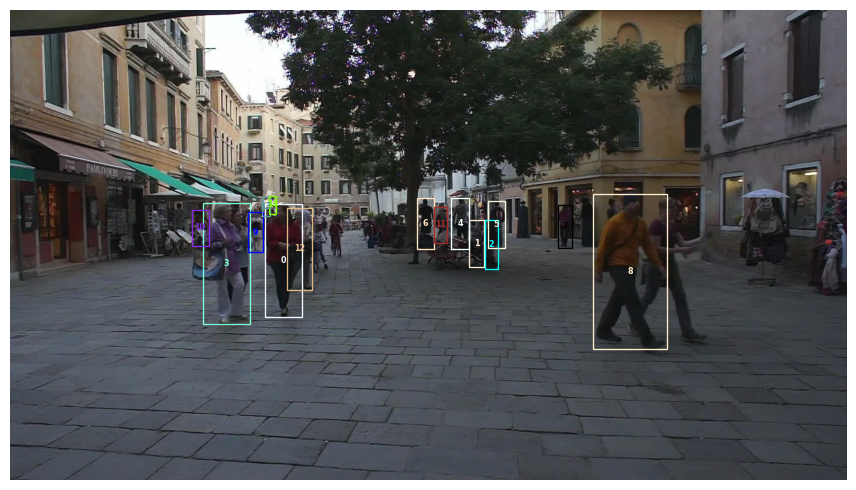

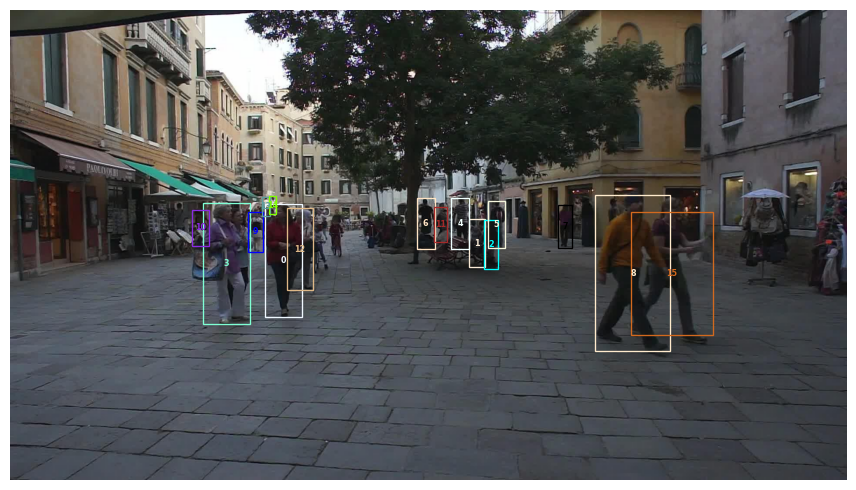

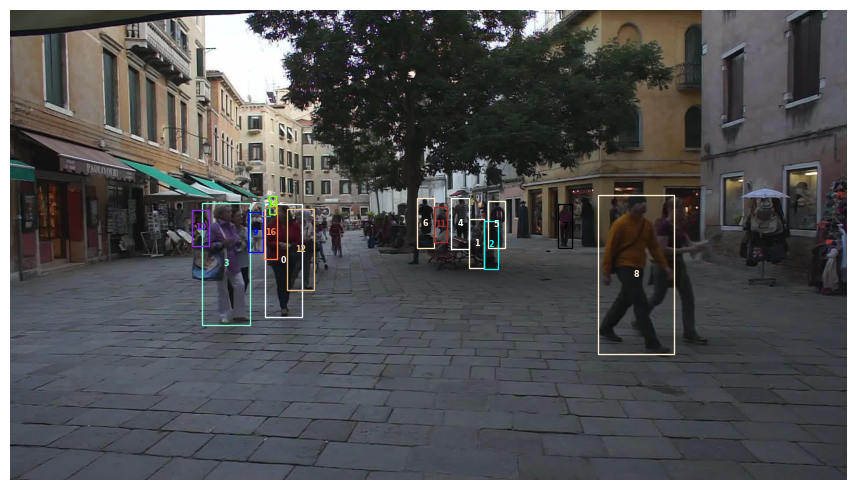

In [60]:
frames = []
for i in range(2):
    frame = plot_sequence2(
        results_seq["MOT16-02"],
        [s for s in val_sequences if str(s) == "MOT16-02"][0],
        first_n_frames=3,
    )

    frames.append(frame)

In [40]:
len(frames)

1

In [38]:
frames[0]

In [ ]:
gif.save(frames, 'example.gif', duration=50)

## old 

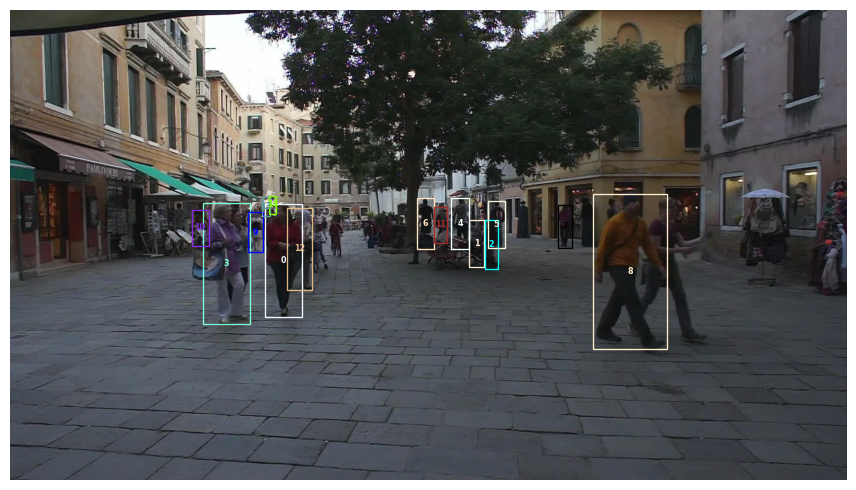

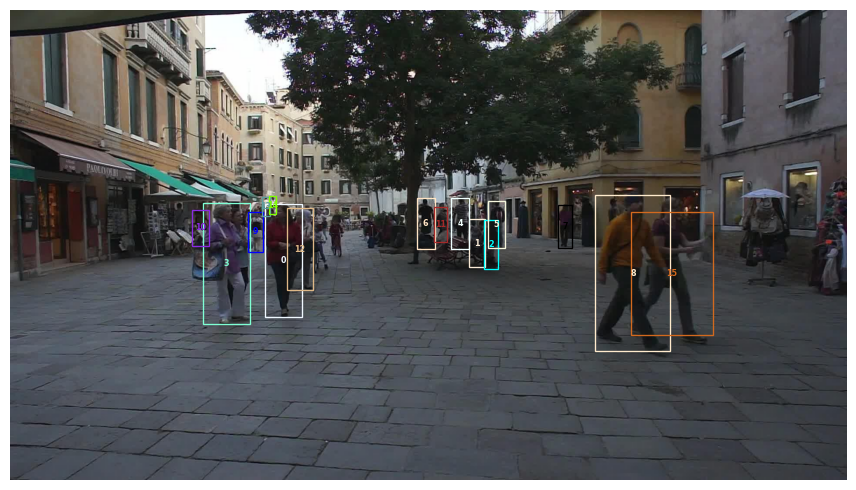

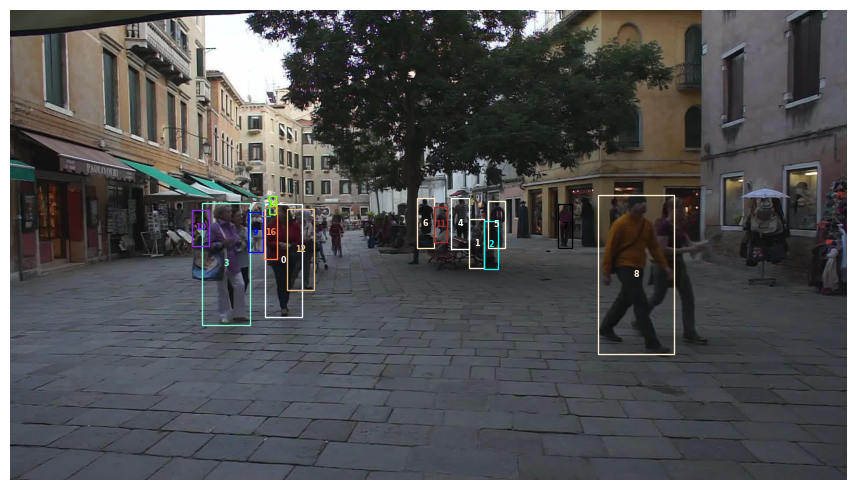

In [55]:
plot_sequence(
    results_seq["MOT16-02"],
    [s for s in sequences if str(s) == "MOT16-02"][0],
    first_n_frames=3,
)


In [22]:
results_seq["MOT16-02"] # [t.box.cpu().numpy(), np.array([t.score])

{0: {0: array([584.55145   , 445.04907   , 669.4421    , 704.5543    ,
           0.99999714], dtype=float32),
  1: array([585.1025    , 446.10538   , 669.4914    , 703.70215   ,
           0.99999714], dtype=float32),
  2: array([585.8408    , 445.89444   , 669.9229    , 704.1525    ,
           0.99999714], dtype=float32),
  3: array([585.5758    , 446.3744    , 669.5082    , 704.1702    ,
           0.99999714], dtype=float32),
  4: array([585.77356   , 446.47705   , 669.10077   , 704.4682    ,
           0.99999714], dtype=float32),
  5: array([585.10284   , 445.9779    , 670.0592    , 704.5802    ,
           0.99999714], dtype=float32),
  6: array([584.8802    , 446.228     , 670.5882    , 704.2709    ,
           0.99999714], dtype=float32),
  7: array([584.88257   , 445.98904   , 671.2655    , 704.14124   ,
           0.99999714], dtype=float32),
  8: array([584.36304   , 445.47064   , 670.7125    , 705.33185   ,
           0.99999714], dtype=float32),
  9: array([584.5925    ,